In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import time
import random
from collections import deque

**Load the MNIST dataset**: You can use the torchvision module to download and load the MNIST dataset.

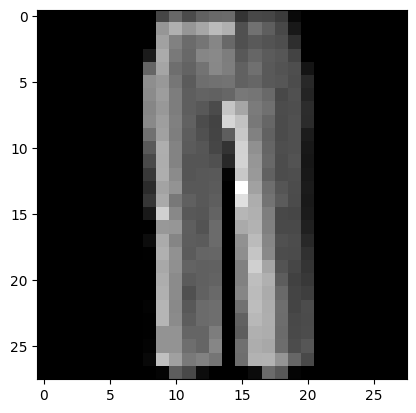

In [2]:
mnistData=torchvision.datasets.FashionMNIST(root='../data', train=True, download=True)

image = mnistData[random.randint(0, len(mnistData) - 1)][0]

# plot a random image
plt.imshow(image, cmap='gray')
plt.show()

**Define the neural network architecture:** You can use PyTorch's nn module to define a simple neural network architecture, such as a feedforward neural network with one hidden layer.

In [4]:
class MnistClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MnistClassifier, self).__init__()
        self.inputLayer = torch.nn.Linear(input_size, hidden_size)
        # TODO do better, use stacks
        self.layer2 = torch.nn.Linear(hidden_size, hidden_size)
        self.layer3 = torch.nn.Linear(hidden_size, hidden_size)
        self.outputLayer = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.inputLayer(x)
        # out = torch.nn.ELU(inplace=True)(self.layer2(out))
        out = self.layer2(out)
        out = self.layer3(out)
        out = torch.nn.ELU(inplace=True)(self.outputLayer(out))
        return out

**Define Hyperparameters**

In [5]:
HIDDEN_LAYER_SIZE = 2048
LEARNING_RATE = 0.01
BATCH_SIZE = 500
EPOCHS = 128

# size of the window used to compute the rolling avgerage of gradient mags
# used to track convergence, must be < epochs
GRADIENT_MAG_ROLLING_AVERAGE_WINDOW_SIZE = 4

**Load dataset** transformations, feature selection

In [6]:
flattenImageTransform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), # Convert the PIL image to a tensor
    torchvision.transforms.Normalize((0.5,), (0.5,)),   # normalize the pixel values
    torchvision.transforms.Lambda(lambda x: x.flatten()), # flatten
])

mnistData.transform = flattenImageTransform

**Initialize classifier**

In [7]:
# set input size using shape of first item; output size to 10 (mnist)
image = mnistData[0][0]
classifier = MnistClassifier(image.shape[0], HIDDEN_LAYER_SIZE, 10)
# print('shape', image.shape)

**Run on GPU?**

In [9]:
# run on GPU?!
print("gpu available!" if torch.cuda.is_available() else "gpu not available")
print("mps available!" if torch.backends.mps.is_available() else "mps not available")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
classifier.to(device)

gpu not available
mps available!


MnistClassifier(
  (inputLayer): Linear(in_features=784, out_features=2048, bias=True)
  (layer2): Linear(in_features=2048, out_features=2048, bias=True)
  (layer3): Linear(in_features=2048, out_features=2048, bias=True)
  (outputLayer): Linear(in_features=2048, out_features=10, bias=True)
)

**Setup getAccuracy function on eval data so we can measure it during training**

In [10]:
evaluationData=torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=flattenImageTransform)
evaluationDataloader = torch.utils.data.DataLoader(evaluationData, batch_size=1024, shuffle=True)

def getAccuracy():
  classifier.eval()  # Set the model to evaluation mode
  correct = 0
  with torch.no_grad():
      for inputs, actuals in evaluationDataloader:
          inputs, actuals = inputs.to(device), actuals.to(device)
          output = classifier(inputs)
          pred = output.argmax(dim=1, keepdim=True)
          correct += pred.eq(actuals.view_as(pred)).sum().item()
  classifier.train() # Set back to training mode
  return 100. * correct / len(evaluationData)

**Train the neural network:** You can use PyTorch's torch.optim module to define an optimizer (such as stochastic gradient descent) and a loss function (such as cross-entropy loss) to train the neural network. You can also use PyTorch's nn module to define a Dataset and a DataLoader to iterate over the training data in mini-batches.

Epoch #1:    Loss: 0.4464    Accuracy: 82.48%    Grad Norm: 0.9214    Rolling Avg: 0.0000    (2.98s)


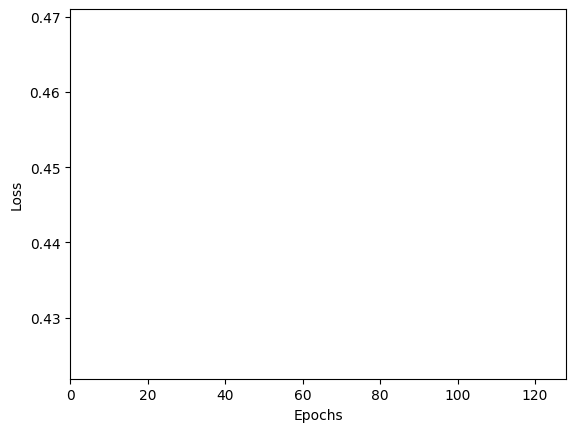

Epoch #2:    Loss: 0.5022    Accuracy: 82.64%    Grad Norm: 0.7286    Rolling Avg: 0.0000    (2.88s)
Epoch #3:    Loss: 0.5058    Accuracy: 82.50%    Grad Norm: 0.9542    Rolling Avg: 0.0000    (2.90s)
Epoch #4:    Loss: 0.4375    Accuracy: 82.88%    Grad Norm: 0.9821    Rolling Avg: 0.8966    (2.85s)
Epoch #5:    Loss: 0.5101    Accuracy: 82.98%    Grad Norm: 0.8728    Rolling Avg: 0.8844    (2.83s)
Training stopped


In [12]:
# loss and optimizer
optimizer = torch.optim.SGD(classifier.parameters(), lr=LEARNING_RATE)
lossFn = torch.nn.CrossEntropyLoss()

# load data
dataloader = torch.utils.data.DataLoader(mnistData, batch_size=BATCH_SIZE, shuffle=True)

# training stats
losses = []
accuracies = []
grad_mag_window = deque(maxlen=GRADIENT_MAG_ROLLING_AVERAGE_WINDOW_SIZE)
grad_mag_rolling_avg = None # rolling avg of gradient magnitudes (for converging)

fig, ax = plt.subplots()
#fig2, ax2 = plt.subplots()

try:
  # training loop:
  for epoch in range(EPOCHS):
    start_time = time.time()

    for inputs, actuals in dataloader:
      # compute on gpu:
      inputs, actuals = inputs.to(device), actuals.to(device)
      # core training routine:
      optimizer.zero_grad()
      predictions = classifier.forward(inputs) # forward prop
      loss = lossFn(predictions, actuals) # get loss
      loss.backward() # compute gradients of weights with respect to loss
      optimizer.step() # apply gradients to weights

    # collect training stats:
    took = time.time() - start_time

    losses.append(loss.item())

    grad_mag = torch.norm(torch.stack([torch.norm(p.grad.detach()) for p in classifier.parameters()]))
    grad_mag_window.append(grad_mag)
    grad_mag_rolling_avg = sum(grad_mag_window) / len(grad_mag_window) \
      if len(grad_mag_window) == grad_mag_window.maxlen \
      else torch.tensor(0)

    accuracy = getAccuracy()
    accuracies.append(accuracy)

    # epoch report:
    print(f"Epoch #{epoch+1}:\
    Loss: {loss.item():.4f}\
    Accuracy: {accuracy:.2f}%\
    Grad Norm: {grad_mag.item():.4f}\
    Rolling Avg: {grad_mag_rolling_avg.item():.4f}\
    ({took:.2f}s)")

    ax.clear()
    ax.plot(losses, color='red', alpha=0.3, label='Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_xlim(0, EPOCHS)
    
    #ax2.clear()
    #ax2.plot(accuracies, color='blue', alpha=0.3, label='Accuracy')
    #ax2.set_xlabel('Epochs')
    #ax2.set_ylabel('Accuracy')
    
    plt.pause(0.1)

except KeyboardInterrupt:
    print('Training stopped')

plt.show()

**Plot Training Stats**

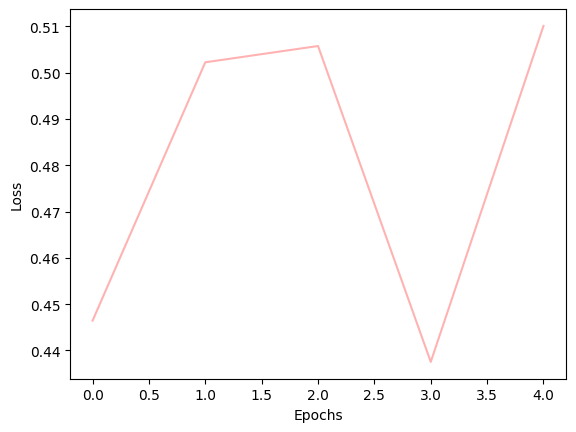

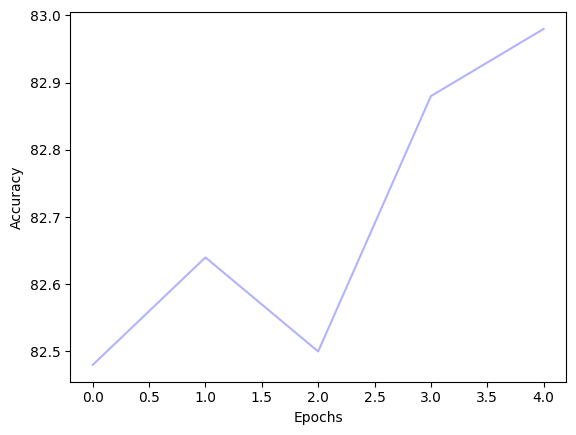

In [13]:
fig, ax = plt.subplots()
ax.plot(losses, color='red', alpha=0.3, label='Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

fig2, ax2 = plt.subplots()
ax2.plot(accuracies, color='blue', alpha=0.3, label='Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

plt.show()


**Evaluate the performance of the neural network:** You can evaluate the performance of the neural network on a validation set (which can be a subset of the MNIST dataset) using metrics such as accuracy or mean squared error. This step helps you assess how well the model is generalizing to new, unseen data, and can be used to fine-tune the model hyperparameters.

In [14]:
test_loss = 0
correct = 0

classifier.eval()
with torch.no_grad():
    for inputs, labels in evaluationDataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        output = classifier(inputs)
        test_loss += torch.nn.functional.nll_loss(output, labels, reduction='sum').item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()

test_loss /= len(evaluationData)
accuracy = 100. * correct / len(evaluationData)
print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
    test_loss, correct, len(evaluationData), accuracy))


Test set: Average loss: -9.6536, Accuracy: 8287/10000 (82.87%)
